# Imports

In [1]:
import torch
import os
import numpy as np
from matplotlib import pyplot as plt
import warnings
import scipy.optimize as opt
warnings.filterwarnings("ignore")


from models.trained_models.unet_wavelet import UNetWavelet

from utils.image_helpers import load_images, plot_image_grid, show_images, rgb2gray, image_to_tensor, tensor_to_image
from utils.configuration_parser.fit_model_configuration import get_fit_model_configuration
from models.model_creation import create_model_from_configuration
from fitting.Fitter import create_fitter_from_configuration
from simulation.Simulation import Simulation
from utils.evaluation_helpers import calculate_full_width_half_maximum_value

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


# Create Image

In [2]:
def create_vertical_contrast(size):
    return np.concatenate((np.ones((size[0],size[1]//2)), np.zeros((size[0],size[1]//2))), axis=1)

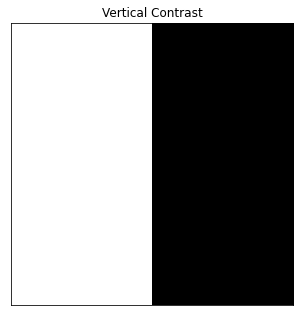

In [3]:
input_size = (256, 256)
original_image = create_vertical_contrast(input_size)
plot = plot_image_grid([original_image], ['Vertical Contrast'], ncols=1)

# Gibbs Simulation

In [4]:
cnr_range = [2, 3, 4, 5, 6, 7, 8, 9, 10]
number_of_runs_per_cnr = 50

In [5]:
noisy_images = []
target_images = []

for cnr in cnr_range:
    sigma = 1/cnr
    simulation = Simulation(cropped_size=(100, 100), pf_factor=8, noise_sigma=sigma)
    for index in range(number_of_runs_per_cnr):
        noisy_image, target_image = simulation(original_image)
        noisy_images.append(noisy_image)
        target_images.append(target_image)
        print(f'{cnr} CNR: {index+1}/{number_of_runs_per_cnr}', end='\r')
    print('')

2 CNR: 50/50
3 CNR: 50/50
4 CNR: 50/50
5 CNR: 50/50
6 CNR: 50/50
7 CNR: 50/50
8 CNR: 50/50
9 CNR: 50/50
10 CNR: 50/50


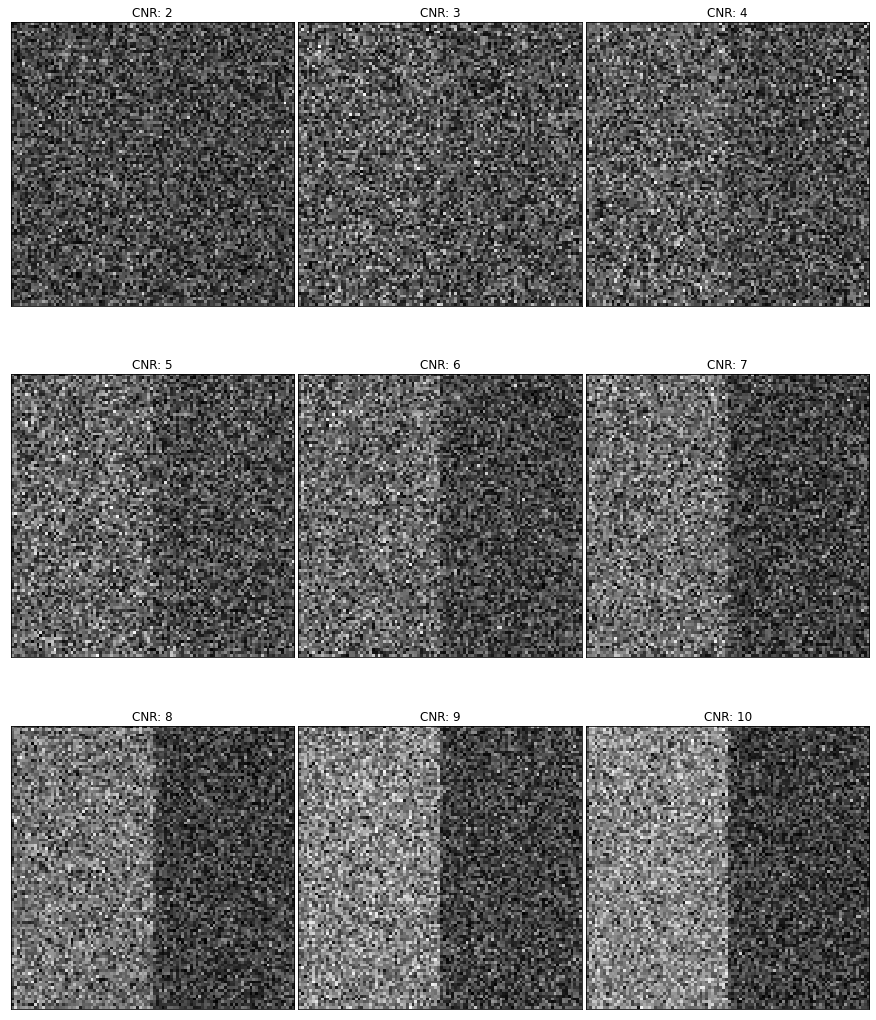

In [6]:
titles = ['CNR: ' + str(x) for x in cnr_range for _ in range(number_of_runs_per_cnr)][::number_of_runs_per_cnr]
plot = plot_image_grid(noisy_images[::number_of_runs_per_cnr], titles, ncols=3)

# Fitting

In [7]:
number_of_runs = 10
fit_model_configuration = get_fit_model_configuration()
fit_model_configuration.model_type = 'deep'
fit_model_configuration.input_shape = [16, 16]
fit_model_configuration.number_of_hidden_channels = 40
fit_model_configuration.number_of_layers = 5
fit_model_configuration.log_frequency = 100
fit_model_configuration.convergence_check_length = None
fit_model_configuration.number_of_iterations = 1000
fit_model_configuration.image_dimensions = [100,100,1]
fit_model_configuration.save_losses = False
fit_model_configuration.result_path = None
print(fit_model_configuration)

image_dimensions: [100, 100, 1]  
result_path: None  
model_type: deep  
input_shape: [16, 16]  
number_of_layers: 5  
number_of_hidden_channels: 40  
number_of_iterations: 1000  
learning_rate: 0.1  
convergence_check_length: None  
log_frequency: 100  
find_best: True  
save_losses: False  
constant_input: False  
data_type: <class 'torch.cuda.FloatTensor'>  



In [8]:
untrained_model_images = []

for image_index, (noisy_image, target_image) in enumerate(zip(noisy_images, target_images)):
    model_images = []
    for run_index in range(number_of_runs):
        model = create_model_from_configuration(fit_model_configuration)
        fitter = create_fitter_from_configuration(fit_model_configuration)
        log_prefix=f'{image_index+1}/{len(noisy_images)}, {run_index+1}/{number_of_runs}; '
        fitter(model, noisy_image, log_prefix=log_prefix)
        model_image = fitter.get_best_image()
        model_images.append(model_image)
    untrained_model_images.append(np.mean(model_images, axis=0))

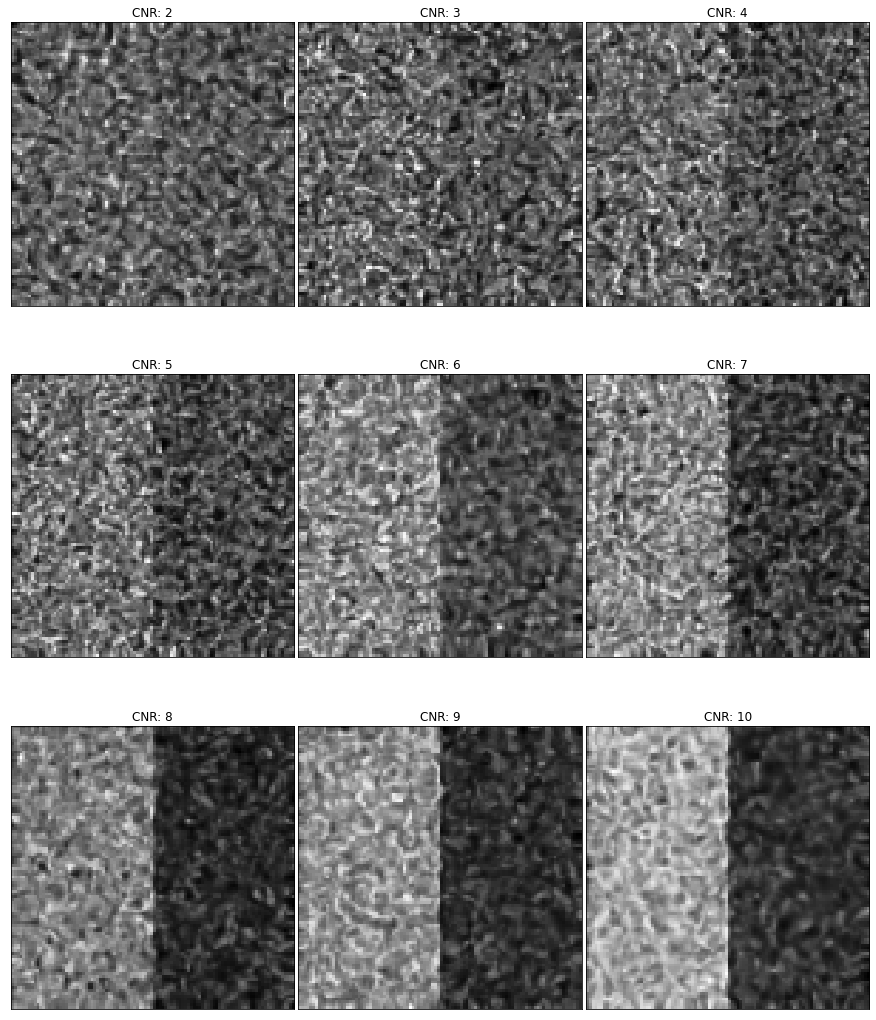

In [9]:
titles = ['CNR: ' + str(x) for x in cnr_range for _ in range(number_of_runs_per_cnr)][::number_of_runs_per_cnr]
plot = plot_image_grid(untrained_model_images[::number_of_runs_per_cnr], titles, ncols=3)

# Load & Apply Trained Model

In [10]:
path = 'models/trained_models/unet_magintude_pffact_8_snrlog0-5_nlayers_10.pt'
trained_model = UNetWavelet(in_ch=1, out_ch=1)
trained_model.load_state_dict(torch.load(path))
trained_model = trained_model.type(dtype)
trained_model = trained_model.eval()
for param in trained_model.parameters():
    param.requires_grad = False
#print(list(trained_model.parameters())[0].shape)
#summary(trained_model, (1, 100, 100), dtypes=[torch.cuda.FloatTensor], depth=3)

In [11]:
trained_model_images = []
for noisy_image in noisy_images:
    noisy_tensor = image_to_tensor(noisy_image).unsqueeze(0).type(dtype)
    trained_image = trained_model(noisy_tensor)
    trained_model_image = tensor_to_image(trained_image.cpu().squeeze(0))
    trained_model_images.append(trained_model_image)

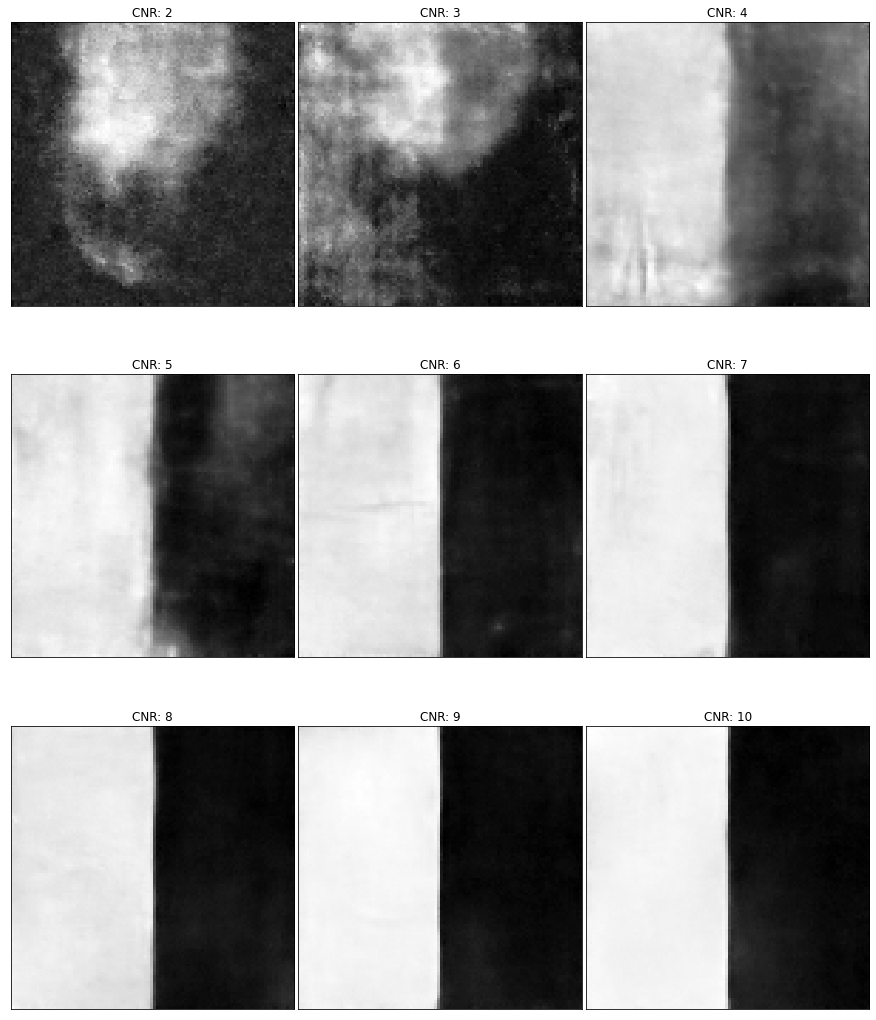

In [12]:
titles = ['CNR: ' + str(x) for x in cnr_range for _ in range(number_of_runs_per_cnr)][::number_of_runs_per_cnr]
plot = plot_image_grid(trained_model_images[::number_of_runs_per_cnr], titles, ncols=3)

# Calculating FWHMs

In [13]:
def logistic_function(x, alpha, beta, gamma):
    return alpha / (1. + np.exp((x - beta) / gamma))


def logistic_sum(x, a1, a2, a3, b1, b2, b3, g1, g2, g3, c):
    alphas = [a1, a2, a3]
    betas = [b1, b2, b3]
    gammas = [g1, g2, g3]
    out = 0.0
    for (alpha, beta, gamma) in zip(alphas, betas, gammas):
        out += logistic_function(x, alpha, beta, gamma)
    out += c
    return out

def logistic_func_with_c(x, alpha, beta, gamma, c):
    return alpha / (1. + np.exp((x - beta) / gamma)) + c


def calculate_vertical_profile(image):
    columns = np.mean(image, axis=0)
    return columns

In [14]:
#Single logistic function
np.seterr(all='ignore')
fwhms = []
fails = []
failed_parameters = []
for image_index, untrained_model_image in enumerate(untrained_model_images):
    #figure, axes = plt.subplots(1, 4, figsize=(18, 6))
    fail_counter = 0
    values = []
    for row_index, row in enumerate(untrained_model_image[:,:,0]):
        print(f'Image: {image_index+1}/{len(untrained_model_images)}; Row: {row_index+1}/{untrained_model_image.shape[0]}   ', end='\r')
        try:
            accuracy_factor = 100
            max_iter= 1000
            number_of_pixels = len(row)
            x = np.linspace(0, number_of_pixels, num=number_of_pixels * accuracy_factor)
            
            alpha_estimates = [1.]
            beta_estimates = [number_of_pixels/2.]
            gamma_estimates = [1.]
            c_estimate = [0.5]
            estimated_parameters = alpha_estimates + beta_estimates + gamma_estimates + c_estimate
            
            lower_alpha_bounds = [0.001]
            upper_alpha_bounds = [np.inf]
            lower_beta_bounds = [0.4 * number_of_pixels]
            upper_beta_bounds = [0.6 * number_of_pixels]
            lower_gamma_bounds = [0.0001]
            upper_gamma_bounds = [25]
            lower_c_bound = [-np.inf]
            upper_c_bound = [np.inf]
            lower_bounds = lower_alpha_bounds + lower_beta_bounds + lower_gamma_bounds + lower_c_bound
            upper_bounds = upper_alpha_bounds + upper_beta_bounds + upper_gamma_bounds + upper_c_bound
            bounds = (np.array(lower_bounds), np.array(upper_bounds))
            
            (a, b, g, c), _ = opt.curve_fit(logistic_func_with_c, np.arange(number_of_pixels), row, p0=estimated_parameters, bounds=bounds, maxfev=max_iter)
            
            extended_x = np.linspace(-number_of_pixels, 2*number_of_pixels, num=number_of_pixels * accuracy_factor)
            
            fitted_row = logistic_func_with_c(extended_x, a, b, g, c)
            #axes[0].plot(extended_x, fitted_row)
            differences = -np.diff(fitted_row)
            half_max = np.max(differences)/2.
            indices = np.where(np.diff(np.sign(differences - half_max)))[0]
            value = (indices[-1] - indices[0])/accuracy_factor
            
            values.append(value)
            #axes[1].plot(1, value, 'o')
            #axes[1].set_title('Successfully calculated FWHMs')
        except RuntimeError:
            fail_counter += 1
            values.append(100)
            #axes[2].plot(row, label=str(row_index))
            #axes[2].legend()
            #axes[2].set_title('Rows that could not be fitted')
        except IndexError:
            fail_counter += 1
            #axes[3].plot(x, fitted_row,label=str(row_index))
            #axes[3].legend()
            #axes[3].set_title('Fitted rows without Maximum')
        #axes[1].set_title(f'Successfully calculated FWHMs: {np.mean(values)}')
    fwhms.append(np.mean(values))
    fails.append(fail_counter)

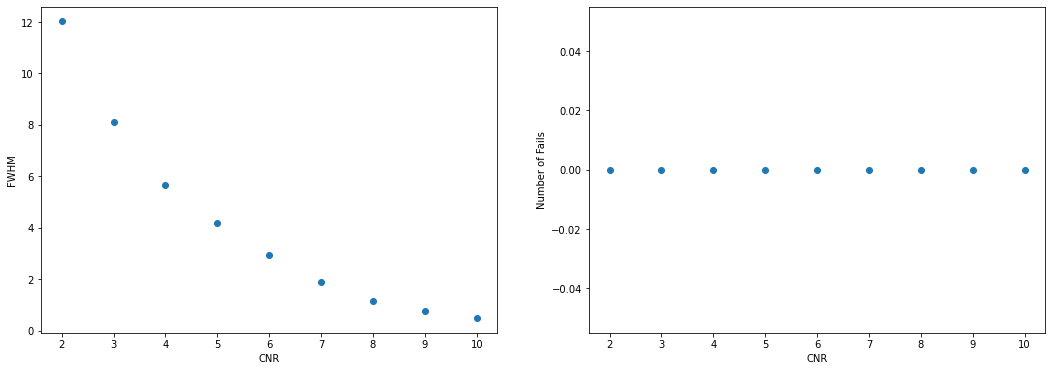

In [15]:
splitted_fwhms = np.split(np.array(fwhms), len(cnr_range))
splitted_fails = np.split(np.array(fails), len(cnr_range))
fwhms_per_cnr = np.mean(splitted_fwhms, axis=1)
fails_per_cnr = np.mean(splitted_fails, axis=1)

figure, axes = plt.subplots(1, 2, figsize=(18, 6))

axes[0].plot(cnr_range, fwhms_per_cnr, 'o')
axes[0].set_xlabel('CNR')
axes[0].set_ylabel('FWHM')
axes[1].plot(cnr_range, fails_per_cnr, 'o')
axes[1].set_xlabel('CNR')
axes[1].set_ylabel('Number of Fails')
plt.show()

In [16]:
#Single logistic function
np.seterr(all='ignore')
fwhms = []
fails = []
failed_parameters = []
for image_index, untrained_model_image in enumerate(trained_model_images):
    #figure, axes = plt.subplots(1, 4, figsize=(18, 6))
    fail_counter = 0
    values = []
    for row_index, row in enumerate(untrained_model_image[:,:,0]):
        print(f'Image: {image_index+1}/{len(untrained_model_images)}; Row: {row_index+1}/{untrained_model_image.shape[0]}   ', end='\r')
        try:
            accuracy_factor = 100
            max_iter= 1000
            number_of_pixels = len(row)
            x = np.linspace(0, number_of_pixels, num=number_of_pixels * accuracy_factor)
            
            alpha_estimates = [1.]
            beta_estimates = [number_of_pixels/2.]
            gamma_estimates = [1.]
            c_estimate = [0.5]
            estimated_parameters = alpha_estimates + beta_estimates + gamma_estimates + c_estimate
            
            lower_alpha_bounds = [0.001]
            upper_alpha_bounds = [np.inf]
            lower_beta_bounds = [0.4 * number_of_pixels]
            upper_beta_bounds = [0.6 * number_of_pixels]
            lower_gamma_bounds = [0.0001]
            upper_gamma_bounds = [25]
            lower_c_bound = [-np.inf]
            upper_c_bound = [np.inf]
            lower_bounds = lower_alpha_bounds + lower_beta_bounds + lower_gamma_bounds + lower_c_bound
            upper_bounds = upper_alpha_bounds + upper_beta_bounds + upper_gamma_bounds + upper_c_bound
            bounds = (np.array(lower_bounds), np.array(upper_bounds))
            
            (a, b, g, c), _ = opt.curve_fit(logistic_func_with_c, np.arange(number_of_pixels), row, p0=estimated_parameters, bounds=bounds, maxfev=max_iter)
            
            extended_x = np.linspace(-number_of_pixels, 2*number_of_pixels, num=number_of_pixels * accuracy_factor)
            
            fitted_row = logistic_func_with_c(extended_x, a, b, g, c)
            #axes[0].plot(extended_x, fitted_row)
            differences = -np.diff(fitted_row)
            half_max = np.max(differences)/2.
            indices = np.where(np.diff(np.sign(differences - half_max)))[0]
            value = (indices[-1] - indices[0])/accuracy_factor
            
            values.append(value)
            #axes[1].plot(1, value, 'o')
            #axes[1].set_title('Successfully calculated FWHMs')
        except RuntimeError:
            fail_counter += 1
            values.append(100)
            #axes[2].plot(row, label=str(row_index))
            #axes[2].legend()
            #axes[2].set_title('Rows that could not be fitted')
        except IndexError:
            fail_counter += 1
            #axes[3].plot(x, fitted_row,label=str(row_index))
            #axes[3].legend()
            #axes[3].set_title('Fitted rows without Maximum')
        #axes[1].set_title(f'Successfully calculated FWHMs: {np.mean(values)}')
    fwhms.append(np.mean(values))
    fails.append(fail_counter)

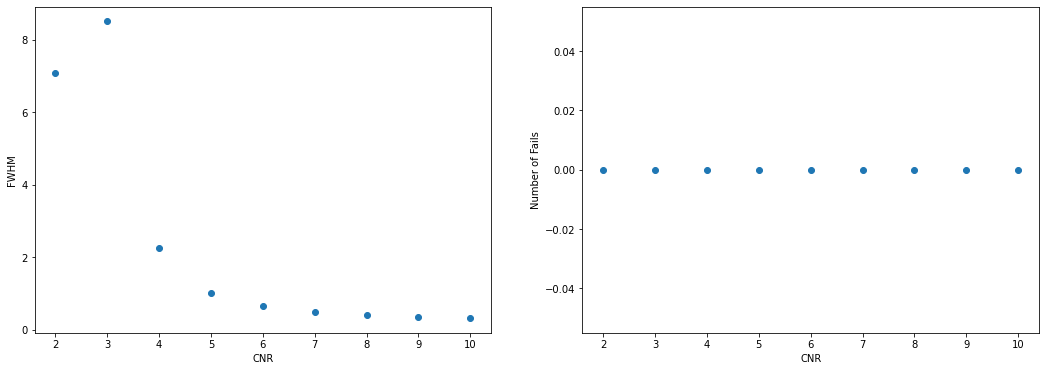

In [17]:
splitted_fwhms = np.split(np.array(fwhms), len(cnr_range))
splitted_fails = np.split(np.array(fails), len(cnr_range))
fwhms_per_cnr = np.mean(splitted_fwhms, axis=1)
fails_per_cnr = np.mean(splitted_fails, axis=1)

figure, axes = plt.subplots(1, 2, figsize=(18, 6))

axes[0].plot(cnr_range, fwhms_per_cnr, 'o')
axes[0].set_xlabel('CNR')
axes[0].set_ylabel('FWHM')
axes[1].plot(cnr_range, fails_per_cnr, 'o')
axes[1].set_xlabel('CNR')
axes[1].set_ylabel('Number of Fails')
plt.show()

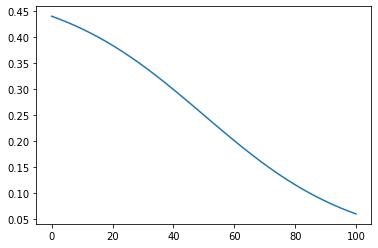

In [18]:
alpha=0.5
beta=50.
gamma=25
c=0.5

test_function = logistic_function(x, alpha, beta, gamma)
plt.plot(x, test_function)
plt.show()